In [26]:
import numpy as np
import re
import matplotlib.pylab as plt 
%matplotlib inline
import os
import tifffile as tiff

Input directories

In [27]:
indir = 'H:\\Fanti_Muscioni\\Y3_Xm45\\'

flatdir = os.path.join(indir, 'flat\\')
darkdir = os.path.join(indir, 'dark\\')
tomodir = os.path.join(indir, 'tomo\\')

outdir = os.path.join(indir, 'out\\')

Create Output directory

In [28]:
if not os.path.exists(outdir):
    os.makedirs(outdir)

Rebin Function

In [29]:
def rebin(img, bin_fact):
    """ 
    Scale the image of a n-factor 
    """
    dim1, dim2 = img.shape
    shape = np.array([dim1/bin_fact, dim2/bin_fact]).astype(int)
    sh = shape[0],img.shape[0]//shape[0],shape[1],img.shape[1]//shape[1]
    return img.reshape(sh).mean(-1).mean(1)

Congrid Function

In [30]:
import scipy.interpolate

def congrid(a, outshape, method="linear"):
    inshape = a.shape
    # catch dimensions error
    if (len(inshape) != 2) or (len(outshape) != 2):
        print("Error: congrid currently only works for 2D arrays.")
    xrange = lambda x: np.linspace(0.5/x, 1.0-0.5/x, x) # make it cell-centered interpolation
    f = scipy.interpolate.interp2d(xrange(inshape[1]), xrange(inshape[0]), a, kind=method)
    a_new = f(xrange(outshape[0]), xrange(outshape[1]))
    return a_new

Numerical Sorter Image Function

In [31]:
def numericalSort(value):
    """ 
    Returns the element in the list or array "value" sorted by their numerical order 
    """
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

Show Image Function

In [32]:
def showImage(img, string, dpi):
    dim1, dim2 = img.shape
    fig = plt.figure(frameon = False)
    fig.set_size_inches(dim1/dpi, dim2/dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(img, cmap = 'gray')
    plt.colorbar()
    plt.title(string)

## Main - Trouble Shooter Flat Field Correction

Take Flats and Darks and perform Subtraction

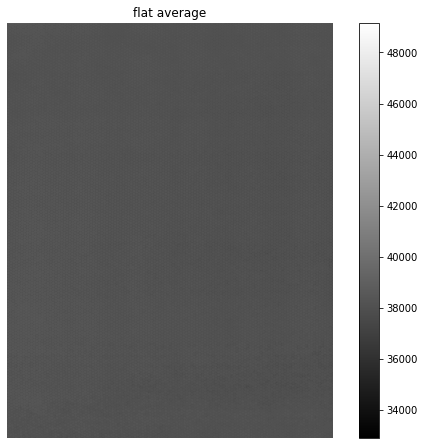

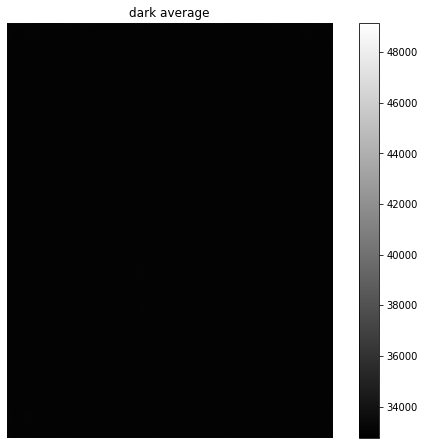

In [33]:
### --- FLAT

flat_list = os.listdir(flatdir)
n_flat = len(flat_list)

flat_n1 = tiff.imread(os.path.join(flatdir, flat_list[0]))
dim1,dim2 = flat_n1.shape

flat_mean = np.zeros([dim1,dim2])
for i in sorted(flat_list, key = numericalSort):
    flat_img = tiff.imread(os.path.join(flatdir,i))
    flat_mean = flat_mean + flat_img 

flat_mean = flat_mean / n_flat
showImage(flat_mean, 'flat average', 400)

### --- DARK

dark_list = os.listdir(darkdir)
n_dark = len(dark_list)

dark_mean = np.zeros([dim1,dim2])
for i in sorted(dark_list, key = numericalSort):
    dark_img = tiff.imread(os.path.join(darkdir,i))
    dark_mean = dark_mean + dark_img

dark_mean = dark_mean / n_dark
showImage(dark_mean,'dark average', 400)

### --- FLAT - DARK

flat_dark = flat_mean - dark_mean

Avoid division per zero and remove corrupted line from images

[[149 816]]


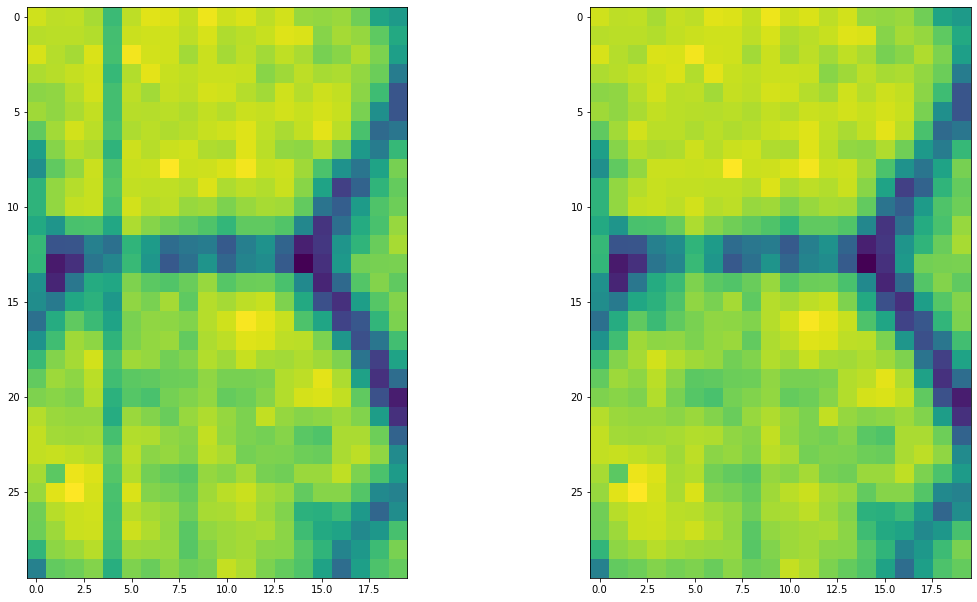

In [34]:
### --- Avoid division per 0
div0 = np.argwhere(flat_dark == 0)
print(div0)
for i in range(div0.shape[0]):
    flat_dark[div0[i,0], div0[i,1]] = 1


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(flat_dark[550:580,1830:1850])

### --- Corrupted line correction

corrupt_line = 1834

kernel_col = np.column_stack((flat_dark[:,(corrupt_line-1)], flat_dark[:,corrupt_line+2]))
flat_dark = np.column_stack((flat_dark[:,:corrupt_line], np.floor(np.median(kernel_col, axis=1)), flat_dark[:,corrupt_line+1:]))

ax2.imshow(flat_dark[550:580,1830:1850])

Enlarge LUT

In [35]:
### --- LUT Normalization

v_max = 1.45 # or 1.25 ?
v_min = 0.0

m = 65535 / (v_max - v_min)
q = m*v_min

ALL TOGETHER LOOP:
+ dead pixels correction, dead areas correction, corrupte column correction
+ binning 2 (in z)
+ flat field correction on two images

In [ ]:
corrupt_value = 32768
corrupt_line = 917#1834
corrupt_pix_x = [513, 649, 743]
corrupt_pix_y = [532, 175, 74]

tomo_list = os.listdir(tomodir)
n_tomo = len(tomo_list)

thr = dim2//2

idx = 0
extracted_lines = []
for i in range(3,6,2):#n_tomo-1,2):
    print(tomo_list[i], '-', tomo_list[i+1])
    img0 = tiff.imread(os.path.join(tomodir, tomo_list[i]))
    img1 = tiff.imread(os.path.join(tomodir, tomo_list[i+1]))
    
    # Save for case 3A
    img_minus1 = img1

    ### --- GET RID OF DEAD-DEAD PIXELS: BOTH IN COLUMN AND SINGLE
    dead_c0 = np.argwhere(img0 == corrupt_value)
    #print(dead_c0)
    dead_c1 = np.argwhere(img1 == corrupt_value)
    #print(dead_c1)
    
    # At First: DEAD COLUMNS PROBLEMS
    # Case 0: do nothing
    # Case 1: first image damaged
    if dead_c0.shape[0] > thr:
        print('first image corrupted')
        for j in range(dead_c0.shape[0]):
            img0[dead_c0[j,0], dead_c0[j,1]] = img1[dead_c0[j,0], dead_c0[j,1]] 
    # Case 2: second image damaged
    elif dead_c1.shape[0] > thr:
        print('second image corrupted')
        for j in range(dead_c1.shape[0]):
            img1[dead_c1[j,0], dead_c1[j,1]] = img0[dead_c1[j,0], dead_c1[j,1]]
    # Case 3: both first and second images damaged
    elif dead_c0.shape[0] > thr and dead_c1.shape[0] > thr:
        img_plus1 = tiff.imread(os.path.join(tomodir, tomo_list[i+2]))
        for j in range(dead_c1.shape[0]):
            for k in range(dead_c0.shape[0]):
                # Case 3A: same region of damage, take the previous image and the next one
                if dead_c0[k,0] == dead_c1[j,0] and dead_c0[k,1] == dead_c1[j,1]:
                    img0[dead_c0[k,0], dead_c0[k,1]] = img_minus1[dead_c0[k,0], dead_c0[k,1]]
                    img1[dead_c1[j,0], dead_c1[j,1]] = img_plus1[dead_c1[j,0], dead_c1[j,1]]
                # Case 3B: not same region of damage 
                else:
                    img0[dead_c0[k,0], dead_c0[k,1]] = img1[dead_c0[k,0], dead_c0[k,1]]
                    img1[dead_c1[j,0], dead_c1[j,1]] = img0[dead_c1[j,0], dead_c1[j,1]]
    
    # Secondly: FEW DEAD PIXELS PROBLEMS
    if dead_c0.shape[0] < thr:
        for j in range(dead_c0.shape[0]):
            pos0 = dead_c0[j,0]
            pos1 = dead_c0[j,1]
            kernel = np.array([img0[pos0-1:pos0+1, pos1-1], img0[pos0-1:pos0+1,pos1+1]])
            img0[pos0, pos1] = np.median(kernel) 
    elif dead_c1.shape[0] < thr:
        for j in range(dead_c1.shape[0]):
            pos0 = dead_c1[j,0]
            pos1 = dead_c1[j,1]
            kernel = np.array([img1[pos0-1:pos0+1, pos1-1], img1[pos0-1:pos0+1,pos1+1]])
            img1[pos0, pos1] = np.median(kernel)
    
    
    
    # DEAD PIXELS COLUMN 
    kernel_col = np.column_stack((img0[:,(corrupt_line-1)], img0[:,corrupt_line+2]))
    img0 = np.column_stack((img0[:,:corrupt_line], np.floor(np.median(kernel_col, axis=1)), img0[:,corrupt_line+1:]))
    kernel_col2 = np.column_stack((img1[:,(corrupt_line-1)], img1[:,corrupt_line+2]))
    img1 = np.column_stack((img1[:,:corrupt_line], np.floor(np.median(kernel_col, axis=1)), img1[:,corrupt_line+1:]))
    
    ### --- FINALLY DO THE FLAT FIELD CORRECTION
    tomo_i0 = np.divide((img0 - dark_mean), (flat_dark))
    tomo_i1 = np.divide((img1 - dark_mean), (flat_dark))
    tomo_img = (tomo_i0 + tomo_i1)/2
    tomo_img = rebin(tomo_img,2)
    tomo_norm = (m*tomo_img)+q
    tomo_out = np.rot90(np.uint16(tomo_norm))

    # MORE DEAD PIXELS
    for j in range(0,len(corrupt_pix_x)):
        pos0 = corrupt_pix_x[j]
        pos1 = corrupt_pix_y[j]
        kernel_r = np.array([tomo_out[pos0-1:pos0+1, pos1-1], tomo_out[pos0-1:pos0+1,pos1+1]])
        tomo_out[pos0, pos1] = np.median(kernel_r)

    tiff.imsave(os.path.join(outdir, 'tomo_' + f'{idx:04}' + '.tif'), tomo_out)

    if i == n_tomo-3:
        print('Spavada finita')
        #showImage(tomo_out, 'tomo ffc', 250)
        break
    idx += 1

### Metodo Saccomano

Rebin after

In [74]:
corrupt_value = 32768
corrupt_line = 917#1834
corrupt_pix_x = [513, 649, 743]
corrupt_pix_y = [532, 175, 74]

tomo_list = os.listdir(tomodir)
n_tomo = len(tomo_list)

thr = dim2//2

idx = 0
extracted_lines = []
for i in range(3,6,2):#n_tomo-1,2):
    print(tomo_list[i], '-', tomo_list[i+1])
    img0 = tiff.imread(os.path.join(tomodir, tomo_list[i]))
    img1 = tiff.imread(os.path.join(tomodir, tomo_list[i+1]))
    
    # Save for case 3A
    img_minus1 = img1

    ### --- GET RID OF DEAD-DEAD PIXELS: BOTH IN COLUMN AND SINGLE
    dead_c0 = np.argwhere(img0 == corrupt_value)
    #print(dead_c0)
    dead_c1 = np.argwhere(img1 == corrupt_value)
    #print(dead_c1)
    
    # At First: DEAD-DEAD COLUMNS PROBLEMS
    # Case 0: do nothing
    # Case 1: first image damaged
    if dead_c0.shape[0] > thr:
        print('first image corrupted')
        for j in range(dead_c0.shape[0]):
            img0[dead_c0[j,0], dead_c0[j,1]] = img1[dead_c0[j,0], dead_c0[j,1]] 
    # Case 2: second image damaged
    elif dead_c1.shape[0] > thr:
        print('second image corrupted')
        for j in range(dead_c1.shape[0]):
            img1[dead_c1[j,0], dead_c1[j,1]] = img0[dead_c1[j,0], dead_c1[j,1]]
    # Case 3: both first and second images damaged
    elif dead_c0.shape[0] > thr and dead_c1.shape[0] > thr:
        img_plus1 = tiff.imread(os.path.join(tomodir, tomo_list[i+2]))
        for j in range(dead_c1.shape[0]):
            for k in range(dead_c0.shape[0]):
                # Case 3A: same region of damage, take the previous image and the next one
                if dead_c0[k,0] == dead_c1[j,0] and dead_c0[k,1] == dead_c1[j,1]:
                    img0[dead_c0[k,0], dead_c0[k,1]] = img_minus1[dead_c0[k,0], dead_c0[k,1]]
                    img1[dead_c1[j,0], dead_c1[j,1]] = img_plus1[dead_c1[j,0], dead_c1[j,1]]
                # Case 3B: not same region of damage 
                else:
                    img0[dead_c0[k,0], dead_c0[k,1]] = img1[dead_c0[k,0], dead_c0[k,1]]
                    img1[dead_c1[j,0], dead_c1[j,1]] = img0[dead_c1[j,0], dead_c1[j,1]]
    
    # Secondly: FEW DEAD-DEAD PIXELS PROBLEMS
    if dead_c0.shape[0] < thr:
        for j in range(dead_c0.shape[0]):
            pos0 = dead_c0[j,0]
            pos1 = dead_c0[j,1]
            kernel = np.array([img0[pos0-1:pos0+1, pos1-1], img0[pos0-1:pos0+1,pos1+1]])
            img0[pos0, pos1] = np.median(kernel) 
    elif dead_c1.shape[0] < thr:
        for j in range(dead_c1.shape[0]):
            pos0 = dead_c1[j,0]
            pos1 = dead_c1[j,1]
            kernel = np.array([img1[pos0-1:pos0+1, pos1-1], img1[pos0-1:pos0+1,pos1+1]])
            img1[pos0, pos1] = np.median(kernel)
    
    ### --- FINALLY DO THE FLAT FIELD CORRECTION
    tomo_i0 = np.divide((img0 - dark_mean), (flat_dark))
    tomo_i1 = np.divide((img1 - dark_mean), (flat_dark))
    tomo_img = (tomo_i0 + tomo_i1)/2
    tomo_img = rebin(tomo_img,2)
    
    # DEAD PIXELS COLUMN 
    kernel_col = np.column_stack((tomo_img[:,(corrupt_line-1)], tomo_img[:,corrupt_line+2]))
    tomo_img = np.column_stack((tomo_img[:,:corrupt_line], np.floor(np.median(kernel_col, axis=1)), tomo_img[:,corrupt_line+1:]))
    
    # MORE DEAD PIXELS
    for j in range(0,len(corrupt_pix_x)):
        pos0 = corrupt_pix_x[j]
        pos1 = corrupt_pix_y[j]
        kernel_r = np.array([tomo_img[pos0-1:pos0+1, pos1-1], tomo_img[pos0-1:pos0+1,pos1+1]])
        tomo_img[pos0, pos1] = np.median(kernel_r)

    # Expand LUT
    tomo_norm = (m*tomo_img)+q

    # Rotate, convert 16 bit and export
    tiff.imsave(os.path.join(outdir, 'tomo_' + f'{idx:04}' + '.tif'), np.rot90(np.uint16(tomo_norm)))

    if i == n_tomo-3:
        print('Spavada finita')
        #showImage(tomo_out, 'tomo ffc', 250)
        break
    idx += 1

tomo_0004.tif - tomo_0005.tif
[[ 302  567]
 [1546 1906]
 [1546 1907]
 ...
 [2393 1595]
 [2393 1596]
 [2393 1597]]
first image corrupted
tomo_0006.tif - tomo_0007.tif
[[302 567]]


Congrid after

In [38]:
dark_mean1 = congrid(dark_mean, (dim2//2, dim1//2))
flat_dark1 = congrid(flat_dark, (dim2//2, dim1//2))

outdir = os.path.join(indir, 'out_congrid_GS\\')
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [68]:
corrupt_value = 32768
corrupt_line = 917 #1834
corrupt_pix_x = [513, 649, 743]
corrupt_pix_y = [532, 175, 74]

tomo_list = os.listdir(tomodir)
n_tomo = len(tomo_list)

idx = 0
extracted_lines = []
for i in range(0,n_tomo-1,2):
    
    print(tomo_list[i], '-', tomo_list[i+1])
    img0 = tiff.imread(os.path.join(tomodir, tomo_list[i]))
    img1 = tiff.imread(os.path.join(tomodir, tomo_list[i+1]))

    dead_c0 = np.argwhere(img0 == corrupt_value)
    #print(dead_c0)
    dead_c1 = np.argwhere(img1 == corrupt_value)
    #print(dead_c1)

    # Save for case 3A
    img_minus1 = img1
    
    # LOT OF DEAD COLUMNS PROBLEM
    # Case 0: do nothing
    # Case 1: first image damaged
    if dead_c0.shape[0] > 1:
        for j in range(dead_c0.shape[0]):
            img0[dead_c0[j,0], dead_c0[j,1]] = img1[dead_c0[j,0], dead_c0[j,1]] 
    # Case 2: second image damaged
    elif dead_c1.shape[0] > 1:
        for j in range(dead_c1.shape[0]):
            img1[dead_c1[j,0], dead_c1[j,1]] = img0[dead_c1[j,0], dead_c1[j,1]]
    # Case 3: both first and second images damaged
    elif dead_c0.shape[0] > 1 and dead_c1.shape[0] > 1:
        img_plus1 = tiff.imread(os.path.join(tomodir, tomo_list[i+2]))
        for j in range(dead_c1.shape[0]):
            for k in range(dead_c0.shape[0]):
                # Case 3A: same region of damage, take the previous image and the next one
                if dead_c0[k,0] == dead_c1[j,0] and dead_c0[k,1] == dead_c1[j,1]:
                    img0[dead_c0[k,0], dead_c0[k,1]] = img_minus1[dead_c0[k,0], dead_c0[k,1]]
                    img1[dead_c1[j,0], dead_c1[j,1]] = img_plus1[dead_c1[j,0], dead_c1[j,1]]
                # Case 3B: not same region of damage 
                else:
                    img0[dead_c0[k,0], dead_c0[k,1]] = img1[dead_c0[k,0], dead_c0[k,1]]
                    img1[dead_c1[j,0], dead_c1[j,1]] = img0[dead_c1[j,0], dead_c1[j,1]]
    
    # A FEW DEAD PIXELS
    if dead_c0.shape[0] == 1:
        pos0 = dead_c0[0,0]
        pos1 = dead_c0[0,1]
        kernel = np.array([img0[pos0-1:pos0+1, pos1-1], img0[pos0-1:pos0+1,pos1+1]])
        img0[dead_c0[0,0], dead_c0[0,1]] = np.median(kernel) 
    elif dead_c1.shape[0] == 1:
        pos0 = dead_c1[0,0]
        pos1 = dead_c1[0,1]
        kernel = np.array([img1[pos0-1:pos0+1, pos1-1], img1[pos0-1:pos0+1,pos1+1]])
        img1[dead_c1[0,0], dead_c1[0,1]] = np.median(kernel)
    
    # DEAD PIXELS COLUMN 
    kernel_col = np.column_stack((img0[:,(corrupt_line-1)], img0[:,corrupt_line+2]))
    img0 = np.column_stack((img0[:,:corrupt_line], np.floor(np.median(kernel_col, axis=1)), img0[:,corrupt_line+1:]))
    kernel_col2 = np.column_stack((img1[:,(corrupt_line-1)], img1[:,corrupt_line+2]))
    img1 = np.column_stack((img1[:,:corrupt_line], np.floor(np.median(kernel_col, axis=1)), img1[:,corrupt_line+1:]))
    
    # FINALLY DO THE FLAT FIELD CORRECTION
    tomo_i0 = np.divide((img0 - dark_mean), (flat_dark))
    tomo_i1 = np.divide((img1 - dark_mean), (flat_dark))
    tomo_img = (tomo_i0 + tomo_i1)/2
    tomo_img = congrid(tomo_img, (dim2//2, dim1//2))
    tomo_norm = (m*tomo_img)+q
    tomo_out = np.rot90(np.uint16(tomo_norm))

    # MORE DEAD PIXELS
    for j in range(0,len(corrupt_pix_x)):
        pos0 = corrupt_pix_x[j]
        pos1 = corrupt_pix_y[j]
        kernel_r = np.array([tomo_out[pos0-1:pos0+1, pos1-1], tomo_out[pos0-1:pos0+1,pos1+1]])
        tomo_out[pos0, pos1] = np.median(kernel_r)

    tiff.imsave(os.path.join(outdir, 'tomo_' + f'{idx:04}' + '.tif'), tomo_out)

    if i == n_tomo-3:
        print('Spavada finita')
        #showImage(tomo_out, 'tomo ffc', 250)
        break
    idx += 1

tomo_0001.tif - tomo_0002.tif
tomo_0003.tif - tomo_0004.tif
tomo_0005.tif - tomo_0006.tif
tomo_0007.tif - tomo_0008.tif
tomo_0009.tif - tomo_0010.tif
tomo_0011.tif - tomo_0012.tif
tomo_0013.tif - tomo_0014.tif
tomo_0015.tif - tomo_0016.tif
tomo_0017.tif - tomo_0018.tif
tomo_0019.tif - tomo_0020.tif
tomo_0021.tif - tomo_0022.tif
tomo_0023.tif - tomo_0024.tif
tomo_0025.tif - tomo_0026.tif
tomo_0027.tif - tomo_0028.tif
tomo_0029.tif - tomo_0030.tif
tomo_0031.tif - tomo_0032.tif
tomo_0033.tif - tomo_0034.tif
tomo_0035.tif - tomo_0036.tif
tomo_0037.tif - tomo_0038.tif
tomo_0039.tif - tomo_0040.tif
tomo_0041.tif - tomo_0042.tif
tomo_0043.tif - tomo_0044.tif
tomo_0045.tif - tomo_0046.tif
tomo_0047.tif - tomo_0048.tif
tomo_0049.tif - tomo_0050.tif
tomo_0051.tif - tomo_0052.tif
tomo_0053.tif - tomo_0054.tif
tomo_0055.tif - tomo_0056.tif
tomo_0057.tif - tomo_0058.tif
tomo_0059.tif - tomo_0060.tif
tomo_0061.tif - tomo_0062.tif
tomo_0063.tif - tomo_0064.tif
tomo_0065.tif - tomo_0066.tif
tomo_0067.

KeyboardInterrupt: 

### Metodo Dreossi

In [63]:
dark_mean1 = congrid(dark_mean, (dim2//2, dim1//2))
flat_dark1 = congrid(flat_dark, (dim2//2, dim1//2))

outdir = os.path.join(indir, 'out_congrid_DD\\')
if not os.path.exists(outdir):
    os.makedirs(outdir)

Congrid before

In [64]:

corrupt_value = 32768
corrupt_line = 917 #1834
corrupt_pix_x = [513, 649, 743]
corrupt_pix_y = [532, 175, 74]

tomo_list = os.listdir(tomodir)
n_tomo = len(tomo_list)

idx = 0
extracted_lines = []
for i in range(0,n_tomo-1,2):
    print(tomo_list[i], '-', tomo_list[i+1])
    img0 = tiff.imread(os.path.join(tomodir, tomo_list[i]))
    #img0 = congrid(img0,(dim2//2, dim1//2))
    img1 = tiff.imread(os.path.join(tomodir, tomo_list[i+1]))
    #img1 = congrid(img1,(dim2//2, dim1//2))

    # GS-Binning before     
    # Save for case 3A
    img_minus1 = img1

    # Discover dead pixels
    dead_c0 = np.argwhere(img0 == corrupt_value)
    #print(dead_c0)
    dead_c1 = np.argwhere(img1 == corrupt_value)
    #print(dead_c1)

    # LOT OF DEAD COLUMNS FROM CRAZY DALSA 
    # Case 1: first image damaged, take the second image
    if dead_c0.shape[0] > 1:
        #print('first not ok')
        img_okcol = img1 
    # Case 2: second image damaged, take the first image
    elif dead_c1.shape[0] > 1:
        #print('second not ok')
        img_okcol = img0
    # Case 3A: both first and second images damaged, take the ok-region of minus1 image and put it in the first image
    elif dead_c0.shape[0] > 1 and dead_c1.shape[0] > 1:
        #print('not not good')
        for j in range(dead_c0.shape[0]):
            img0[dead_c0[j,0], dead_c0[j,1]] = img_minus1[dead_c0[j,0], dead_c0[j,1]]
        img_okcol = img0
    # Case 3B: both first and second images damaged, take the ok-region of plus1 image and put it in the second image
    #elif dead_c1.shape[0] > dim1-1:
    #    img_plus1 = tiff.imread(os.path.join(tomodir, tomo_list[i+2]))
    #    for j in range(dead_c0.shape[0]):
    #        img1[dead_c0[j,0], dead_c0[j,1]] = img_plus1[dead_c0[j,0], dead_c0[j,1]]
    #    img_okcol = img1
    # Case 0: no column trouble, sum images
    else:
        #print('ok')
        img_okcol = img0 #(img0 + img1)/2

    # CORRECT A FEW DEAD PIXELS
    dead_okcol = np.argwhere(img_okcol == corrupt_value)
    #print(dead_okcol)
    if dead_okcol.shape[0] == 1:
        pos0 = dead_okcol[0,0]
        pos1 = dead_okcol[0,1]
        kernel = np.array([img_okcol[pos0-1:pos0+1, pos1-1], img_okcol[pos0-1:pos0+1,pos1+1]])
        img_okcol[dead_okcol[0,0], dead_okcol[0,1]] = np.median(kernel) 

    # DEAD PIXELS COLUMN 
    kernel_col = np.column_stack((img_okcol[:,(corrupt_line-1)], img_okcol[:,corrupt_line+2]))
    img_okcol = np.column_stack((img_okcol[:,:corrupt_line], np.floor(np.median(kernel_col, axis=1)), img_okcol[:,corrupt_line+1:]))
    #tiff.imsave(os.path.join(outdir, 'tomo0_' + f'{idx:04}' + '.tif'), img_okcol)

    # FINALLY DO THE FLAT FIELD CORRECTION
    #tomo_img = np.divide((img_okcol - dark_mean1), (flat_dark1))
    tomo_img = np.divide((img_okcol - dark_mean), (flat_dark))
    #tiff.imsave(os.path.join(outdir, 'tomo1_' + f'{idx:04}' + '.tif'), tomo_img)
    tomo_img = congrid(tomo_img,(dim2//2, dim1//2))
    tomo_norm = (m*tomo_img)+q
    #tiff.imsave(os.path.join(outdir, 'tomo2_' + f'{idx:04}' + '.tif'), tomo_norm)
    tomo_out = np.rot90(np.uint16(tomo_norm))
    
    # MORE DEAD PIXELS
    for j in range(0,len(corrupt_pix_x)):
        pos0 = corrupt_pix_x[j]
        pos1 = corrupt_pix_y[j]
        kernel_r = np.array([tomo_out[pos0-1:pos0+1, pos1-1], tomo_out[pos0-1:pos0+1,pos1+1]])
        tomo_out[pos0, pos1] = np.median(kernel_r)
    

    # Save image
    tiff.imsave(os.path.join(outdir, 'tomo_' + f'{idx:04}' + '.tif'), tomo_out)
    if i == n_tomo-3:
        print('Spavada finita')
        #showImage(tomo_out, 'tomo ffc', 250)
        break
    idx += 1

tomo_0001.tif - tomo_0002.tif
tomo_0003.tif - tomo_0004.tif
tomo_0005.tif - tomo_0006.tif
tomo_0007.tif - tomo_0008.tif
tomo_0009.tif - tomo_0010.tif
tomo_0011.tif - tomo_0012.tif
tomo_0013.tif - tomo_0014.tif
tomo_0015.tif - tomo_0016.tif
tomo_0017.tif - tomo_0018.tif
tomo_0019.tif - tomo_0020.tif
tomo_0021.tif - tomo_0022.tif
tomo_0023.tif - tomo_0024.tif
tomo_0025.tif - tomo_0026.tif
tomo_0027.tif - tomo_0028.tif
tomo_0029.tif - tomo_0030.tif
tomo_0031.tif - tomo_0032.tif
tomo_0033.tif - tomo_0034.tif
tomo_0035.tif - tomo_0036.tif
tomo_0037.tif - tomo_0038.tif
tomo_0039.tif - tomo_0040.tif
tomo_0041.tif - tomo_0042.tif
tomo_0043.tif - tomo_0044.tif
tomo_0045.tif - tomo_0046.tif
tomo_0047.tif - tomo_0048.tif
tomo_0049.tif - tomo_0050.tif
tomo_0051.tif - tomo_0052.tif
tomo_0053.tif - tomo_0054.tif
tomo_0055.tif - tomo_0056.tif
tomo_0057.tif - tomo_0058.tif
tomo_0059.tif - tomo_0060.tif
tomo_0061.tif - tomo_0062.tif
tomo_0063.tif - tomo_0064.tif
tomo_0065.tif - tomo_0066.tif
tomo_0067.

Rebin before

In [65]:
dark_mean2 = rebin(dark_mean, 2)
flat_dark2 = rebin(flat_dark, 2)

outdir = os.path.join(indir, 'out_rebin_DD\\')
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [67]:
corrupt_value = 32768
corrupt_line = 917 #1834
corrupt_pix_x = [513, 649, 743]
corrupt_pix_y = [532, 175, 74]

tomo_list = os.listdir(tomodir)
n_tomo = len(tomo_list)

idx = 0
extracted_lines = []
for i in range(0,n_tomo-1,2):
    print(tomo_list[i], '-', tomo_list[i+1])
    img0 = tiff.imread(os.path.join(tomodir, tomo_list[i]))
    #img0 = rebin(img0,2)
    img1 = tiff.imread(os.path.join(tomodir, tomo_list[i+1]))
    #img1 = rebin(img1,2)

    # GS-Binning before     
    # Save for case 3A
    img_minus1 = img1

    # Discover dead pixels
    dead_c0 = np.argwhere(img0 == corrupt_value)
    #print(dead_c0)
    dead_c1 = np.argwhere(img1 == corrupt_value)
    #print(dead_c1)

    # LOT OF DEAD COLUMNS FROM CRAZY DALSA 
    # Case 1: first image damaged, take the second image
    if dead_c0.shape[0] > 1:
        img_okcol = img1 
    # Case 2: second image damaged, take the first image
    elif dead_c1.shape[0] > 1:
        img_okcol = img0
    # Case 3A: both first and second images damaged, take the ok-region of minus1 image and put it in the first image
    elif dead_c0.shape[0] > 1 and dead_c1.shape[0] > 1:
        for j in range(dead_c0.shape[0]):
            img0[dead_c0[j,0], dead_c0[j,1]] = img_minus1[dead_c0[j,0], dead_c0[j,1]]
        img_okcol = img0
    # Case 3B: both first and second images damaged, take the ok-region of plus1 image and put it in the second image
    #elif dead_c1.shape[0] > dim1-1:
    #    img_plus1 = tiff.imread(os.path.join(tomodir, tomo_list[i+2]))
    #    for j in range(dead_c0.shape[0]):
    #        img1[dead_c0[j,0], dead_c0[j,1]] = img_plus1[dead_c0[j,0], dead_c0[j,1]]
    #    img_okcol = img1
    # Case 0: no column trouble, sum images
    else:
        img_okcol = img0 #(img0 + img1)/2
    
    # CORRECT A FEW DEAD PIXELS
    dead_okcol = np.argwhere(img_okcol == corrupt_value)
    if dead_okcol.shape[0] == 1:
        pos0 = dead_okcol[0,0]
        pos1 = dead_okcol[0,1]
        kernel = np.array([img_okcol[pos0-1:pos0+1, pos1-1], img_okcol[pos0-1:pos0+1,pos1+1]])
        img_okcol[dead_okcol[0,0], dead_okcol[0,1]] = np.median(kernel) 

    # DEAD PIXELS COLUMN 
    kernel_col = np.column_stack((img_okcol[:,(corrupt_line-1)], img_okcol[:,corrupt_line+2]))
    img_okcol = np.column_stack((img_okcol[:,:corrupt_line], np.floor(np.median(kernel_col, axis=1)), img_okcol[:,corrupt_line+1:]))

    # FINALLY DO THE FLAT FIELD CORRECTION
    #tomo_img = np.divide((img_okcol - dark_mean2), (flat_dark2))
    tomo_img = np.divide((img_okcol - dark_mean), (flat_dark))
    tomo_norm = (m*tomo_img)+q
    tomo_out = np.rot90(np.uint16(tomo_norm))
    tomo_out = rebin(tomo_out,2)
    
    # MORE DEAD PIXELS
    for j in range(0,len(corrupt_pix_x)):
        pos0 = corrupt_pix_x[j]
        pos1 = corrupt_pix_y[j]
        kernel_r = np.array([tomo_out[pos0-1:pos0+1, pos1-1], tomo_out[pos0-1:pos0+1,pos1+1]])
        tomo_out[pos0, pos1] = np.median(kernel_r)
    
    # Save image
    tiff.imsave(os.path.join(outdir, 'tomo_' + f'{idx:04}' + '.tif'), np.uint16(tomo_out))
    if i == n_tomo-3:
        print('Spavada finita')
        #showImage(tomo_out, 'tomo ffc', 250)
        break
    idx += 1

tomo_0001.tif - tomo_0002.tif
tomo_0003.tif - tomo_0004.tif
tomo_0005.tif - tomo_0006.tif
tomo_0007.tif - tomo_0008.tif
tomo_0009.tif - tomo_0010.tif
tomo_0011.tif - tomo_0012.tif
tomo_0013.tif - tomo_0014.tif
tomo_0015.tif - tomo_0016.tif
tomo_0017.tif - tomo_0018.tif
tomo_0019.tif - tomo_0020.tif
tomo_0021.tif - tomo_0022.tif
tomo_0023.tif - tomo_0024.tif
tomo_0025.tif - tomo_0026.tif
tomo_0027.tif - tomo_0028.tif
tomo_0029.tif - tomo_0030.tif
tomo_0031.tif - tomo_0032.tif
tomo_0033.tif - tomo_0034.tif
tomo_0035.tif - tomo_0036.tif
tomo_0037.tif - tomo_0038.tif
tomo_0039.tif - tomo_0040.tif
tomo_0041.tif - tomo_0042.tif
tomo_0043.tif - tomo_0044.tif
tomo_0045.tif - tomo_0046.tif
tomo_0047.tif - tomo_0048.tif
tomo_0049.tif - tomo_0050.tif
tomo_0051.tif - tomo_0052.tif
tomo_0053.tif - tomo_0054.tif
tomo_0055.tif - tomo_0056.tif
tomo_0057.tif - tomo_0058.tif
tomo_0059.tif - tomo_0060.tif
tomo_0061.tif - tomo_0062.tif
tomo_0063.tif - tomo_0064.tif
tomo_0065.tif - tomo_0066.tif
tomo_0067.